In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as tf
from torchvision.datasets import CIFAR100

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import gc

In [4]:
from functools import partial
from typing import Type, Any, Callable, Union, List, Optional


from torch import Tensor

In [ ]:
#stats is used for normalization
stat1 = torch.Tensor([0.5071, 0.4865, 0.4409])
stat2 = torch.Tensor([0.2009, 0.1984, 0.2023])
stats = stat1, stat2
stats

#torchvision.transforms.Compose
train_transforms = tf.Compose([
    tf.RandomHorizontalFlip(),
    tf.RandomCrop(32, padding=4, padding_mode='reflect'),
    tf.ToTensor(),
    tf.Normalize(*stats, inplace=True)
])
test_transforms = tf.Compose([
    tf.ToTensor(),
    tf.Normalize(*stats)
])

#make custom cifar100 dataset
train_data = CIFAR100(download=True, train=True, root="../data", transform=train_transforms)
test_data = CIFAR100(download=True, train=False, root='../data', transform=test_transforms)

In [6]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

<h3><u><b><i>model : ResNet

In [7]:
class ResNet(nn.Module):
    # model = ResNet(Bottleneck, [3, 4, 6, 3], 100, true) #resnet 50 
    def __init__(self, block, initial_conv, layers, channels, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
                
        #input = 3x32x32
        self.conv1 = nn.Conv2d(3, initial_conv, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.inplanes = initial_conv 

        self.bn1 = nn.BatchNorm2d(initial_conv)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, channels[0], layers[0])
        self.layer2 = self._make_layer(block, channels[1], layers[1])
        self.layer3 = self._make_layer(block, channels[2], layers[2])
        # self.layer4 = self._make_layer(block, channels[3], layers[3])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[-1] * block.expansion, num_classes) #Linear(2048(layer4's nb_output_channel), num_classes)
    
        # weight initialization!
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
    
    

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
    
        if stride != 1 or self.inplanes != planes * block.expansion: 
            
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride), 
                nn.BatchNorm2d(planes * block.expansion), 
            )

        layers = [] 
        layers.append(block(self.inplanes, planes, stride, downsample)) 
        
        self.inplanes = planes * block.expansion 
        
        for _ in range(1, blocks): 
            layers.append(block(self.inplanes, planes)) 
            
        return nn.Sequential(*layers)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        #x = self.block_list(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [8]:
import torchvision.models.resnet as resnet

conv1x1 = resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock = resnet.BasicBlock

In [9]:
def train_model(_model, _epoch, _train_data_loader, _optimizer, _lr_sche,  _creterion, _array_cost, _array_accu, _array_lr):
    train_cost_sum = 0
    corrects = 0
    len_dataloader = len(_train_data_loader)
    print('----------------train----------------')
    for batch_idx, data in enumerate(_train_data_loader):
        x, y = data
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        _optimizer.zero_grad()
        prediction = _model(x)
        corrects += (prediction.argmax(1) == y).sum().item()
        cost = creterion(prediction, y)
        cost.backward()
        _optimizer.step()
        _lr_sche.step()
        _array_lr.append(get_lr(_optimizer))

        train_cost_sum += cost.item()
        if (batch_idx + 1) % (len_dataloader//3) == 0:
            train_cost_avg = train_cost_sum / (batch_idx + 1)
            print('Epoch:{:2d}/{} batch_idx:{:3d} Train Cost:{:2.6f}'
            .format(_epoch, TRAIN_EPOCHS, batch_idx+1, train_cost_avg))
    
    accuracy = (corrects / len(train_data))*100
    print('Epoch:{:2d}/{} batch_idx:{:3d} Train Accuracy:{:2.6f}'
            .format(_epoch, TRAIN_EPOCHS, batch_idx+1, accuracy))
    _array_cost.append(train_cost_sum/len(_train_data_loader))
    _array_accu.append(accuracy)
        

In [10]:
def test_model(_model, _epoch, _test_data_loader, _creterion, _array_cost, _array_accu):
    test_cost_avg = 0
    corrects = 0
    print('----------------test----------------')
    for batch_idx, data in enumerate(_test_data_loader):
        x, y = data
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = _model(x)
        
        corrects += (prediction.argmax(1) == y).sum().item()
        cost = _creterion(prediction, y)
        test_cost_avg += cost.item()/len(_test_data_loader)

    accuracy = (corrects / len(test_data)) * 100
    print('Epoch:{:2d}/{} Test Cost:{:2.6f} Test Accuracy:{:.4f}'
            .format(_epoch, TRAIN_EPOCHS, test_cost_avg, accuracy))
    _array_cost.append(test_cost_avg)
    _array_accu.append(accuracy)

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [12]:
BATCH_SIZE = 96
train_data_loader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True, drop_last=True)
test_data_loader = torch.utils.data.DataLoader(test_data, BATCH_SIZE, num_workers=4, pin_memory=True)

In [13]:
print('train data set shape', len(train_data))
print('test data set shape', len(test_data))

for data in train_data_loader:
    x, y = data
    print('x shape', x.shape)
    print('y shape', y.shape)

    break
train_iteration = len(train_data)/BATCH_SIZE

print('data_loader length', len(train_data_loader))

train data set shape 50000
test data set shape 10000
x shape torch.Size([96, 3, 32, 32])
y shape torch.Size([96])
data_loader length 520


In [ ]:
DEVICE = 'cuda:0' #if you can't use GPU, edit 'cuda:0' as 'cpu'
LEARNING_RATE = 0.01
TRAIN_EPOCHS = 100
initial_conv = 64
layer = [3,5,2] 
channels = [128, 256, 512]

model_resnet = ResNet(BasicBlock, initial_conv, layer, channels, 100, True).to(DEVICE)
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
optimizer = optim.Adam(model_resnet.parameters(), lr=LEARNING_RATE)
lr_sche = optim.lr_scheduler.OneCycleLR(optimizer, LEARNING_RATE, epochs=TRAIN_EPOCHS, steps_per_epoch=len(train_data_loader))

creterion = nn.CrossEntropyLoss().to(DEVICE)
train_cost_arr = []
train_accu_arr = []
test_cost_arr = []
test_accu_arr = []
x_array = []
lr_array = []
str_layer = '|'.join(map(str, layer))
str_channels = '|'.join(map(str, channels))

for epoch in range(TRAIN_EPOCHS):
    x_array.append(epoch + 1)
    train_cost_sum = 0
    test_cost_avg = 0

    model_resnet.train()
    train_model(model_resnet, epoch+1, train_data_loader, optimizer, lr_sche, creterion, train_cost_arr,train_accu_arr, lr_array)
    
    model_resnet.eval()
    test_model(model_resnet, epoch+1, test_data_loader, creterion, test_cost_arr, test_accu_arr)

    
    plt.subplot(1,2,1)
    plt.plot(x_array, train_cost_arr, 'r', label='train cost')
    plt.plot(x_array, test_cost_arr, 'g', label='test cost')
    plt.xlabel('EPOCH')
    plt.ylabel('Cost')
    plt.title('Train(r)/Test(g) Cost vs Epoch')
    
    plt.subplot(1,2,2)
    plt.plot(x_array, train_accu_arr, 'r', label='train accu')
    plt.plot(x_array, test_accu_arr, 'g', label='test accu')
    plt.xlabel('EPOCH')
    plt.ylabel('ACCURACY')
    plt.title('Train(r)/Test(g) ACCURACY vs Epoch')
    
    plt.rcParams["figure.figsize"] = (17,5)
    plt.rcParams['axes.grid'] = True 
    plt.show()

    plt.plot([x for x in range(len(lr_array))], lr_array, 'b')
    plt.xlabel('minibatch')
    plt.ylabel('learning rate')
    plt.title('learning rate per iteration')
    plt.show()

torch.save(model_resnet, '../trained_models/resnet{}_epoch{}_ly{}_ch{}_accu_L|M{:2.2f}|{:2.2f}.pt'.format((sum(layer)*2 + 2),TRAIN_EPOCHS, str_layer, str_channels, test_accu_arr[-1], max(test_accu_arr)))

<h4><u><b> Plot final graphs

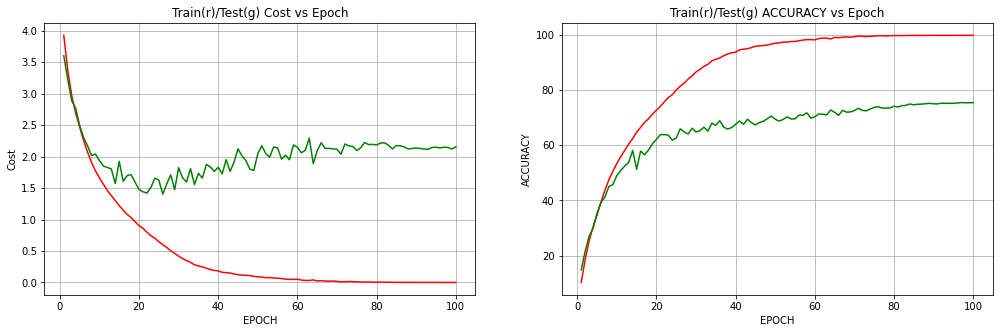

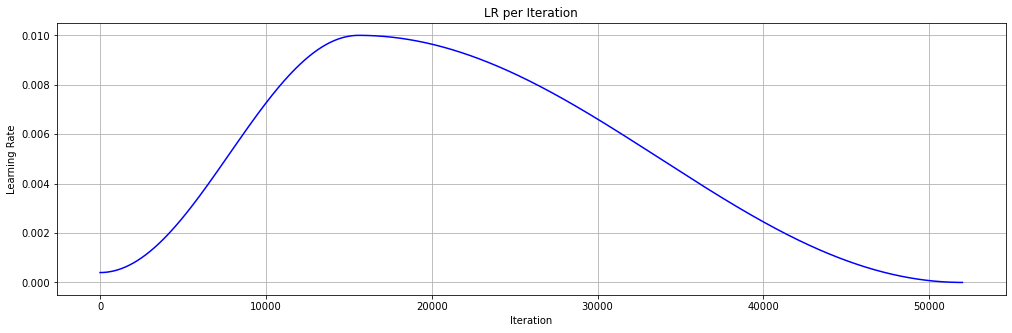

In [16]:
plt.rcParams["figure.figsize"] = (17,5)
plt.rcParams['axes.grid'] = True 

plt.subplot(1,2,1)
plt.plot(x_array, train_cost_arr, 'r', label='train cost')
plt.plot(x_array, test_cost_arr, 'g', label='test cost')
plt.xlabel('EPOCH')
plt.ylabel('Cost')
plt.title('Train(r)/Test(g) Cost vs Epoch')

plt.subplot(1,2,2)
plt.plot(x_array, train_accu_arr, 'r', label='train accu')
plt.plot(x_array, test_accu_arr, 'g', label='test accu')
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.title('Train(r)/Test(g) ACCURACY vs Epoch')
plt.show()

plt.plot([x for x in range(len(lr_array))], lr_array, 'b', label='lr per iteration')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('LR per Iteration')
plt.show()

<h4><b><u> Testing model with no graph.

In [19]:
#this code takes some time..! but very accurate!
DEVICE = 'cuda:0'

def test_model_no_graph(_model, _test_data):
    corrects = 0
    _model.to(DEVICE)
    _model.eval()
    print('----------------evaluating model----------------')
    for idx, data in enumerate(_test_data):
        x, y = data
        x = x.float().to(DEVICE)
        x.unsqueeze_(0)
        prediction = _model(x)
        corrects += (prediction.argmax(1).item() == y)
        #print(corrects, '/', idx)

    return corrects/len(test_data)

model_loaded = torch.load('../trained_models/resnet22_epoch100_ly3|5|2_ch128|256|512_accu_L|M75.42|75.46.pt')    
model_loaded = model_loaded.to(DEVICE)
test_accuracy = test_model_no_graph(model_loaded, test_data)
print('Test Accuracy', test_accuracy * 100, '%')

----------------evaluating model----------------
Test Accuracy 75.4 %


<h3> <u> <b> Clear GPU

In [ ]:
#If you want be sure to clear cache, I recommand to restart kernel
#The codes below is the next best thing.

gc.collect()
torch.cuda.empty_cache()